<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-обработка-данных" data-toc-modified-id="Загрузка-и-обработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и обработка данных</a></span><ul class="toc-item"><li><span><a href="#Обработка-дискретных-признаков" data-toc-modified-id="Обработка-дискретных-признаков-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обработка дискретных признаков</a></span></li><li><span><a href="#Оценка-важности-признаков" data-toc-modified-id="Оценка-важности-признаков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Оценка важности признаков</a></span></li><li><span><a href="#Обработка-числовых-признаков" data-toc-modified-id="Обработка-числовых-признаков-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Обработка числовых признаков</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Извлечение-выборок" data-toc-modified-id="Извлечение-выборок-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Извлечение выборок</a></span></li><li><span><a href="#Введение-инструмента-оценки-адекватности" data-toc-modified-id="Введение-инструмента-оценки-адекватности-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Введение инструмента оценки адекватности</a></span></li><li><span><a href="#Линейные-модели" data-toc-modified-id="Линейные-модели-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Линейные модели</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#Ridge" data-toc-modified-id="Ridge-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#ElasticNet" data-toc-modified-id="ElasticNet-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>ElasticNet</a></span></li></ul></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Выбор-лучшей-модели" data-toc-modified-id="Выбор-лучшей-модели-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Выбор лучшей модели</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import make_scorer, mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

# Загрузка и обработка данных

In [3]:
try:
    data = pd.read_csv('autos.csv')    
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Выведем три случайных записи из датасета

In [4]:
data.sample(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
176741,2016-03-10 17:57:09,1200,wagon,2005,manual,115,mondeo,150000,5,NaN,ford,yes,2016-03-10 00:00:00,0,41236,2016-03-13 00:15:30
228617,2016-03-27 14:56:11,10500,wagon,2008,auto,143,a4,150000,8,gasoline,audi,no,2016-03-27 00:00:00,0,7646,2016-04-07 11:45:21
298577,2016-03-27 19:52:37,2800,sedan,1999,manual,101,bora,150000,2,petrol,volkswagen,no,2016-03-27 00:00:00,0,1156,2016-04-05 18:16:11


Прежде чем начать обработку датасета, разделим слова в названии признаков нижним подчеркиванием и приведем их к нижнему регистру

In [5]:
def snake_caser(word):
    word = list(word)
    for i in range(1, len(word)):
        if word[-i].isupper():
            word.insert(-i, '_')
    return(''.join(word).lower())

In [6]:
data.columns = [snake_caser(word) for word in list(data.columns)]

Почтовый индекс владельца анкеты мог помочь выявить некоторые региональные особенности рынков подержанных авто, но для этого потребовалось бы подтверждение составителя датасета, так как почтовые индексы разных стран могут формироваться по разным стандартам и совпадать. Подавляющее число наблюдений относится к немецкому рынку. Ограничимся этим знанием и удалим столбец с почтовым индексом.

In [8]:
data = data.drop('postal_code', axis=1)

Выведем сводную таблицу по датасету, совмещающую в себе функции методов `info()` и `describe()`, а также подсчитывающую количество пропущенных значений

In [9]:
def full_info(df):
    display(pd.DataFrame({'Non-Null Count': (~df.isna()).sum(), 
                          'Null Count': df.isna().sum(), 
                          'Dtype': df.dtypes}).join(df.describe().T).rename_axis('Feature', axis=1).fillna(''))

In [10]:
full_info(data)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
date_crawled,354369,0,object,,,,,,,,
price,354369,0,int64,354369,4416.66,4514.16,0,1050,2700,6400,20000
vehicle_type,316879,37490,object,,,,,,,,
registration_year,354369,0,int64,354369,2004.23,90.228,1000,1999,2003,2008,9999
gearbox,334536,19833,object,,,,,,,,
power,354369,0,int64,354369,110.094,189.85,0,69,105,143,20000
model,334664,19705,object,,,,,,,,
kilometer,354369,0,int64,354369,128211,37905.3,5000,125000,150000,150000,150000
registration_month,354369,0,int64,354369,5.71464,3.72642,0,3,6,9,12
fuel_type,321474,32895,object,,,,,,,,


Видны следующие проблемы:
* несоответствие типов во временных признаках
* большое количество пропусков в категориальных признаках
* Выбросы в числовых признаках

Начнем с приведения признаков к корректным типам данных

In [11]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'])
data['date_created'] = pd.to_datetime(data['date_created'])
data['last_seen'] = pd.to_datetime(data['last_seen'])

В столбце с числом фотографий одни нули, убедимся в этом и удалим признак

In [12]:
display(data['number_of_pictures'].value_counts())
data = data.drop('number_of_pictures', axis=1)

0    354369
Name: number_of_pictures, dtype: int64

## Обработка дискретных признаков

Займемся обработкой категориальных переменных, в которых были пропуски. Начнем с форм-фактора кузова. Тип кузова можно достаточно однозначно определить по модели. Конечно, есть риск, что одна и та же модель выпускается с разным кузовом, или тип кузова может быть неоднозначно определен автором объявления. Рассмотрим, как пользователи определяли форм-фактор разных моделей.

In [13]:
data.groupby(['brand', 'model'])['vehicle_type'].unique().to_frame().sample(5)

,,vehicle_type
brand,model,
chrysler,voyager,"[bus, nan, other, sedan, wagon, suv]"
audi,200,"[sedan, convertible, nan, wagon]"
chrysler,crossfire,"[convertible, coupe, nan, other]"
ford,fiesta,"[small, nan, sedan, bus, wagon, coupe, convert..."
volkswagen,eos,"[convertible, nan]"


Выведем частоту упоминания каждого типа автомобиля

In [14]:
vehicletype_pivot = data.groupby(['brand', 'model'])['vehicle_type'].value_counts().to_frame()
vehicletype_pivot.head(10)

vehicle_type
brand      model vehicle_type              
alfa_romeo 145   small                   19
                 sedan                   13
                 coupe                    2
                 other                    1
           147   sedan                  358
                 small                   97
                 coupe                   27
                 other                    7
                 wagon                    2
                 suv                      1

Итак, форму автомобиля можно с определенной вероятностью восстановить по марке и модели. Напишем соответствующую функцию

In [16]:
def vehicletype_filler(row):
    if pd.isna(row['vehicle_type']) and not pd.isna(row['model']):
        return vehicletype_pivot.loc[(row['brand'], row['model']), :].index[0]
    return row['vehicle_type']

In [18]:
def get_brand_model_dict(data, col):
    return data.groupby(['brand', 'model'])[col].agg(lambda x: x.value_counts(dropna=False).index[0]).to_dict()

In [19]:
def feature_filler(row, col, brand_model_dict):
    
    if pd.isna(row[col]) and not pd.isna(row['model']):
        return brand_model_dict.get((row['brand'], row['model']))
    return row[col]

In [21]:
%%time
display(data['vehicle_type'].value_counts())

for col in ['vehicle_type', 'fuel_type', 'gearbox']:
    column_brand_model_dict = get_brand_model_dict(data, col)
    data[col] = data.apply(feature_filler, col=col, brand_model_dict=column_brand_model_dict, axis=1)
    
display(data['vehicle_type'].value_counts())

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

sedan          104115
small           88946
wagon           68707
bus             32534
convertible     20475
coupe           16780
suv             12666
other            3313
Name: vehicle_type, dtype: int64

Wall time: 22.8 s


Рассмотрим, какие значения есть у признака `notrepaired`

In [22]:
data['not_repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [23]:
data['not_repaired'].value_counts()

no     247161
yes     36054
Name: not_repaired, dtype: int64

Вероятно, у признака не совсем верное название, и на самом деле лишь капитальному ремонту подвергается лишь каждая девятая машина, а  не наоборот. Подтвердим это расчетом среднего года выпуска ремонтированных и неремонтированных машин.

In [24]:
print('not_repaired=yes', data[data['not_repaired']=='yes']['registration_year'].mean())
print('not_repaired=no', data[data['not_repaired']=='no']['registration_year'].mean())

not_repaired=yes 2001.6177955289288
not_repaired=no 2003.7621267109294


Но восстановим данные согласно заданию

In [25]:
data['not_repaired'] = data['not_repaired'].fillna(False)
data['not_repaired'] = data['not_repaired'].replace('no', False)
data['not_repaired'] = data['not_repaired'].replace('yes', True)

In [26]:
data['not_repaired'].value_counts()

False    318315
True      36054
Name: not_repaired, dtype: int64

## Оценка важности признаков

Оценим важность признаков по простым моделям - линейной регрессии и случайному лесу

In [27]:
protodata = data.drop(['date_crawled', 'date_created', 'last_seen'], axis=1).dropna()
proto_features = protodata.drop('price', axis=1)
proto_target = protodata['price']

proto_data_train_features, proto_data_test_features, proto_data_train_target, proto_data_test_target = train_test_split(proto_features, 
                                                                                                                        proto_target, 
                                                                                                                        test_size=0.2,
                                                                                                                        random_state=123)
proto_train_indexes = proto_data_train_features.index
proto_test_indexes = proto_data_test_features.index

In [28]:
protodata_ohe = pd.get_dummies(protodata, columns=['vehicle_type', 
                                                   'gearbox', 
                                                   'model', 
                                                   'fuel_type', 
                                                   'brand', 
                                                   'not_repaired'], drop_first=True)
proto_data_train_features_ohe = protodata_ohe.loc[proto_train_indexes].drop('price', axis=1)
proto_data_test_features_ohe = protodata_ohe.loc[proto_test_indexes].drop('price', axis=1)

In [29]:
proto_numeric_features = ['registration_year', 'power', 'kilometer', 'registration_month']

scaler = StandardScaler()
scaler.fit(proto_data_train_features[proto_numeric_features]);

In [30]:
proto_data_train_features_ohe_scaled = proto_data_train_features_ohe
proto_data_train_features_ohe_scaled.loc[:, proto_numeric_features] = scaler.transform(proto_data_train_features_ohe[proto_numeric_features])

proto_data_test_features_ohe_scaled = proto_data_test_features_ohe
proto_data_test_features_ohe_scaled.loc[:, proto_numeric_features] = scaler.transform(proto_data_test_features_ohe[proto_numeric_features])

In [31]:
proto_model_lr = LinearRegression(n_jobs=-1)
proto_model_lr.fit(proto_data_train_features_ohe_scaled, proto_data_train_target);
proto_model_lr_predicted = proto_model_lr.predict(proto_data_test_features_ohe_scaled)

Проведем проверку модели на адекватность, сравнив метрику предсказания модели с предсказанием среднего целевого признака по обучающей выборке

In [32]:
print('RMSE модели:', mse(proto_data_test_target, proto_model_lr_predicted, squared=False))
print('RMSE предсказания средним:', mse(proto_data_test_target, len(proto_data_test_target)*[proto_data_train_target.mean()], squared=False))

RMSE модели: 3211.356846410017
RMSE предсказания средним: 4518.845325464483


Построим графики с распределением коэффициентов линейной регрессии

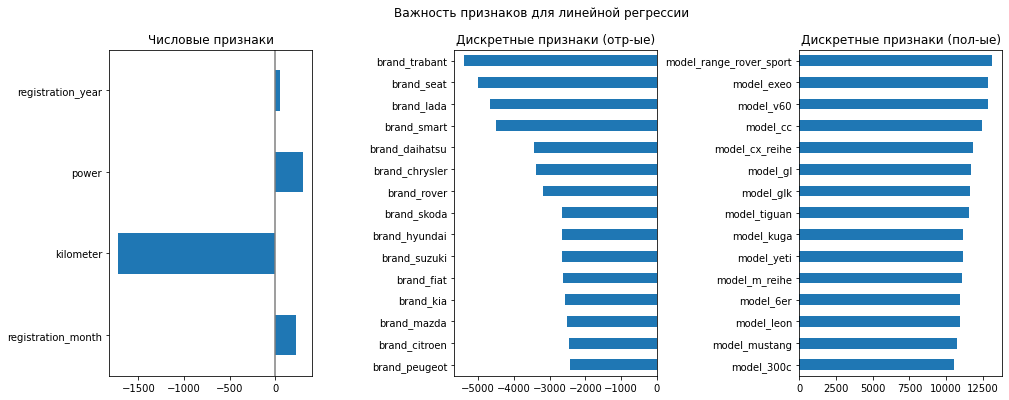

In [33]:
plt.figure(figsize=(16,6))
plt.suptitle('Важность признаков для линейной регрессии')

plt.subplot(1,3,1)
pd.Series(proto_model_lr.coef_, index=proto_data_train_features_ohe_scaled.columns)[proto_numeric_features][::-1].plot(kind='barh');
plt.title('Числовые признаки')
plt.axvline(x=0, color='grey');

plt.subplot(1, 3, 2)
pd.Series(proto_model_lr.coef_, index=proto_data_train_features_ohe_scaled.columns).sort_values().head(15)[::-1].plot(kind='barh');
plt.title('Дискретные признаки (отр-ые)')

plt.subplot(1, 3, 3)
pd.Series(proto_model_lr.coef_, index=proto_data_train_features_ohe_scaled.columns).sort_values(ascending=False).head(15)[::-1].plot(kind='barh');
plt.title('Дискретные признаки (пол-ые)');

plt.subplots_adjust(wspace=0.7)

Итак, среди числовых признаков сильнее всего на цену влияет ее пробег. На основе этого вывода мы будем принимать решение об исключении признаков из модели обучения. Про дискретные признаки на основе линейной регрессии мы такие выводы сделать не можем.

Проведем проверку важности признаков по модели случайного леса

In [34]:
proto_model_rfr = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=123, n_jobs=-1)
proto_model_rfr.fit(proto_data_train_features_ohe_scaled, proto_data_train_target)
proto_model_rfr_predicted = proto_model_rfr.predict(proto_data_test_features_ohe_scaled)

Проведем проверку модели на адекватность, сравнив метрику предсказания модели с предсказанием среднего целевого признака по обучающей выборке

In [35]:
print('RMSE модели:', mse(proto_data_test_target, proto_model_rfr_predicted, squared=False))
print('RMSE предсказания средним:', mse(proto_data_test_target, len(proto_data_test_target)*[proto_data_train_target.mean()], squared=False))

RMSE модели: 2021.858764933303
RMSE предсказания средним: 4518.845325464483


Построим графики с важностью признаков

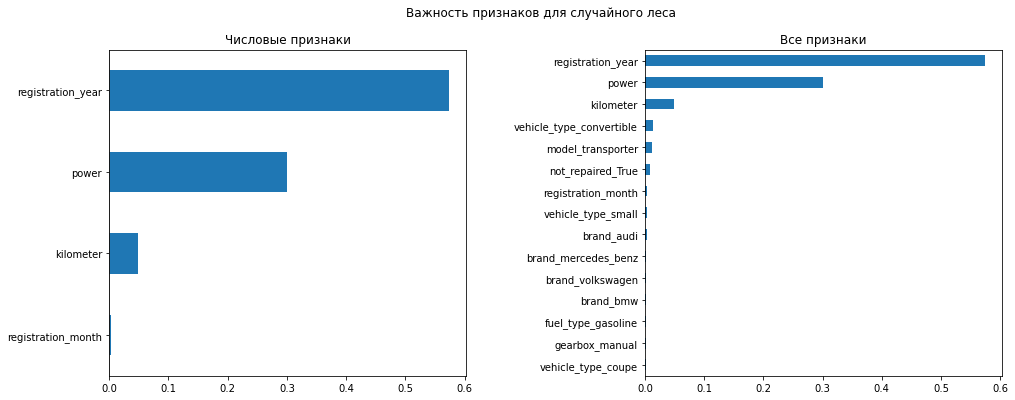

In [36]:
plt.figure(figsize=(16,6))
plt.suptitle('Важность признаков для случайного леса')

plt.subplot(1,2,1)
pd.Series(proto_model_rfr.feature_importances_, index=proto_data_train_features_ohe_scaled.columns)[proto_numeric_features][::-1].plot(kind='barh');
plt.title('Числовые признаки')
plt.axvline(x=0, color='grey');

plt.subplot(1, 2, 2)
pd.Series(proto_model_rfr.feature_importances_, index=proto_data_train_features_ohe_scaled.columns).sort_values(ascending=False).head(15)[::-1].plot(kind='barh');
plt.title('Все признаки');

plt.subplots_adjust(wspace=0.5)

Итак, по версии случайного леса, в основном цена зависит от числовых признаков: года регистрации, мощности и пробега. Месяц регистрации и отдельные дискретные признаки на цену влияют незначительно.

**Выводы**

* Из датасета можно удалить признак `registrationmonth`
* Оценка важности проводилась для неочищенного датасета, в котором (как это станет видно позднее) у целевого признака есть много выбросов

## Обработка числовых признаков

Удалим из датасета месяц регистрации автомобиля

In [37]:
data = data.drop('registration_month', axis=1)

Построим распределения оставшихся числовых признаков

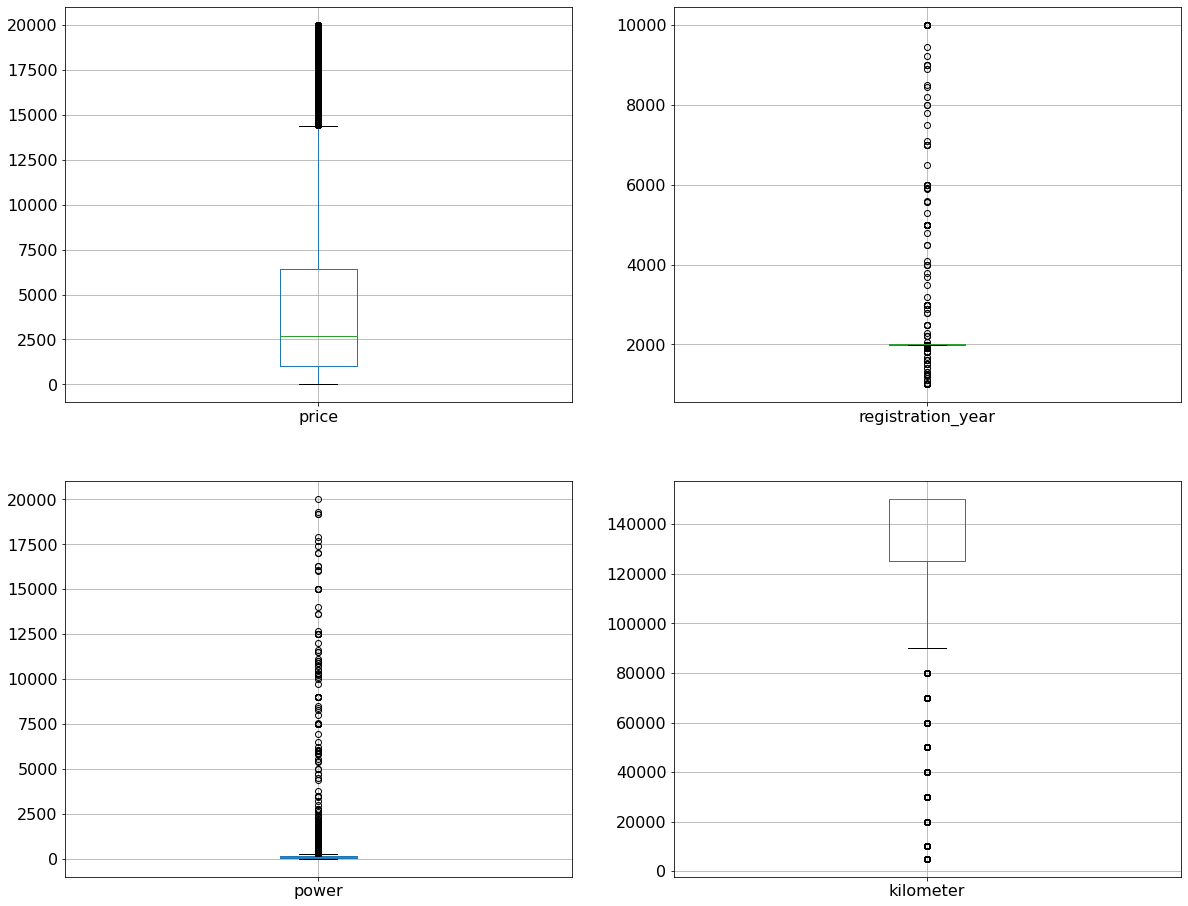

In [38]:
plt.figure(figsize=(20, 16))

for i, feature in enumerate(['price', 'registration_year', 'power', 'kilometer']):
    ax = plt.subplot(2, 2, i+1)
    data.boxplot(column=feature, fontsize=16)

Целью проекта является предсказание цены автомобиля, поэтому объявления, в которых указана низкая или нулевая цена, исключим из датасета. Согласно данным площадки подержанных машин в Германии https://www.ooyyo.com/germany/used-cars-for-sale/c=CDA31D7114D3854F111BFE6FAA652D53EDA2/, цена автомобилей начинается от 100 евро. Это, как правило, машины, нуждающиеся в ремонте, поэтому удалим из датасета машины с ценой менее 200 евро

In [39]:
data = data[data['price']>200].reset_index(drop=True)

Год выпуска (регистрации) автомобиля явно коррелирует с ценой, поэтому этот признак нужно обработать. Проверим, нет ли в датасете объявлений, в которых дата регистрации машины позднее, чем дата создания объявления, его скачивания и последней активности пользователя 

In [40]:
display(data[data['registration_year']>data['date_crawled'].dt.year].shape[0])
display(data[data['registration_year']>data['date_created'].dt.year].shape[0])
display(data[data['registration_year']>data['last_seen'].dt.year].shape[0])

13577

13577

13577

Посмотрим, что это за данные

In [41]:
data[data['registration_year']>data['date_crawled'].dt.year]['registration_year'].value_counts().head(5)

2017    9742
2018    3758
2019      14
9999      12
5000      11
Name: registration_year, dtype: int64

Большая часть из них относится к 2017-2019 годам, и теоретически это могут быть настоящие адекватные объвления. Следовало бы обратиться к составителю датасета за объяснением временных признаков, но чтобы не терять ценные наблюдения, примем решение заменить год выпуска медианой.

Определим нижний порог адекватной даты регистрации автомобиля

In [42]:
data[data['registration_year']<1930]['registration_year'].value_counts()

1910    25
1000    20
1929     6
1800     4
1234     3
1600     2
1928     2
1923     2
1500     2
1602     1
1111     1
1300     1
1039     1
1001     1
1927     1
1925     1
1400     1
Name: registration_year, dtype: int64

То, что единичные раритетные машины могли быть выпущены в двадцатых, можно легко себе представить, но все значения ниже 1900 года заменим медианой. Также поступим с пропусками

In [43]:
data.loc[(data['registration_year']<1900) | (data['registration_year']>2019), 'registration_year'] = data['registration_year'].median()
data['registration_year'] = data['registration_year'].fillna(data['registration_year'].median())

Данные о создании объявления, его скачивании и последней активности пользователя в целом больше не нужны. Их тоже можно удалить.

In [44]:
data = data.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)

Рассмотрим диаграмму плотности распределения указанных в объявлениях мощностей автомобилей

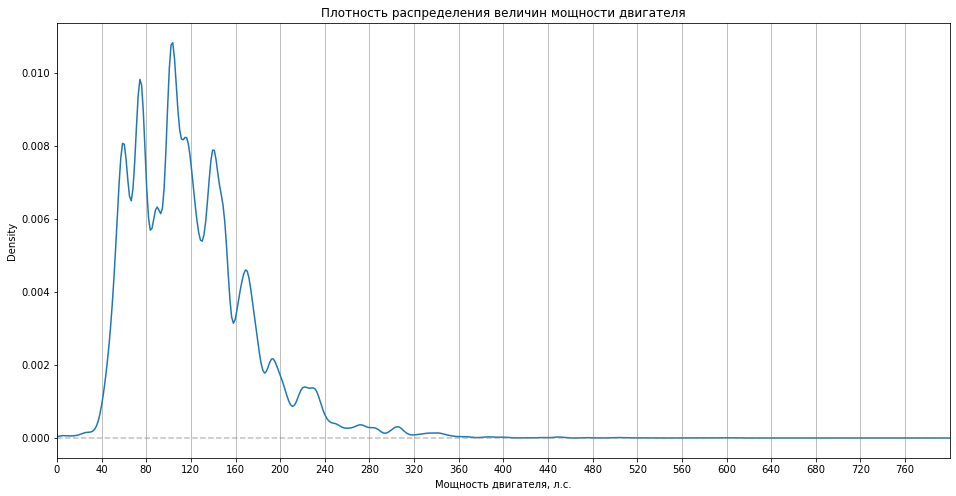

In [45]:
plt.figure(figsize=(16, 8))
data[(data['power']>0)&(data['power']<800)]['power'].plot.kde()
plt.xlim([0, 800])
plt.axhline(y=0, color='grey', alpha=0.5, linestyle='--')
plt.xticks(range(0, 800, 40))
plt.grid(b=True, axis='x')
plt.title('Плотность распределения величин мощности двигателя')
plt.xlabel('Мощность двигателя, л.с.');

Наблюдается большой всплеск околонулевых значений, а автомобилей с мощностью выше 600 лошадиных сил практически нет. Заменим оба этих диапазона на меданное значение мощности двигателя. То же самое сделаем с пропусками.

In [46]:
data.loc[(data['power']<40) | (data['power']>600), 'power'] = data['power'].median()
data['power'] = data['power'].fillna(data['power'].median())

Рассмотрим распределение пробега

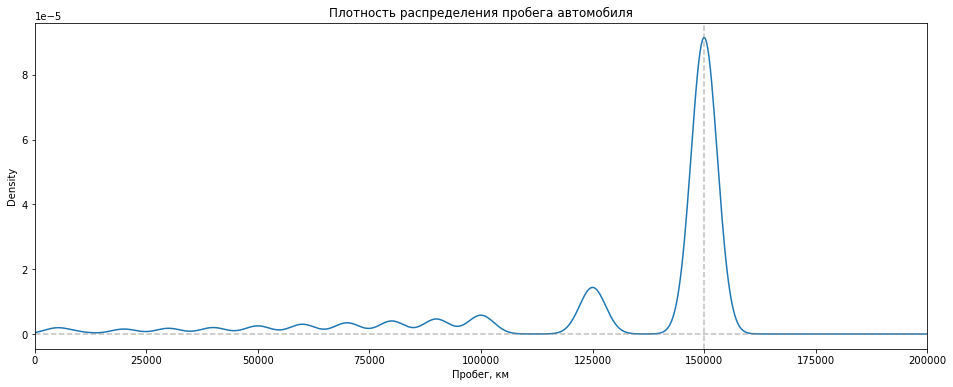

In [47]:
plt.figure(figsize=(16, 6))
data['kilometer'].plot.kde();
plt.xlim([0, 2e5])
plt.axhline(y=0, color='grey', alpha=0.5, linestyle='--')
plt.axvline(x=150000, color='grey', alpha=0.5, linestyle='--')
plt.title('Плотность распределения пробега автомобиля')
plt.xlabel('Пробег, км');

Для подавляющего большинства автомобилей пробег проставлен в формате "больше 150 тыс. км", что наделяет этот признак дискретными свойствами. С другой стороны, реальный пробег вряд ли в разы превосходит это пороговое значение, поэтому даже если в будущем на сайте площадки станет возможно указывать бОльшее значение пробега, модель не будет сильно ошибаться.

Оценим количество оставшихся наблюдений

In [48]:
data.shape

(334921, 10)

Записей стало примерно на 6% меньше, удалены только те наблюдения, по которым отсутствует адекватное значение целевой переменной.

# Обучение моделей

## Извлечение выборок

In [49]:
features = data.drop('price', axis=1)
target = data['price']

In [50]:
data_train_features, data_test_features, data_train_target, data_test_target = train_test_split(features, 
                                                                                                target, 
                                                                                                test_size=0.2,
                                                                                                random_state=123)
train_indexes = data_train_features.index
test_indexes = data_test_features.index

In [51]:
data_train_features

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
253172,wagon,1997,auto,133,galant,150000,petrol,mitsubishi,False
66834,convertible,1997,manual,90,megane,150000,petrol,renault,False
324206,small,2004,manual,69,ka,150000,petrol,ford,False
15700,wagon,2012,manual,131,insignia,150000,gasoline,opel,False
67596,wagon,2007,manual,170,passat,125000,gasoline,volkswagen,False
...,...,...,...,...,...,...,...,...,...
192476,bus,2018,manual,105,kangoo,150000,petrol,renault,False
17730,sedan,2016,manual,114,3_reihe,150000,petrol,mazda,False
28030,suv,2012,manual,143,x_reihe,50000,gasoline,bmw,False
277869,wagon,2007,manual,105,astra,125000,petrol,opel,False


Закодируем дискретные переменные по технике OHE

In [52]:
data_ohe = pd.get_dummies(features, columns=['vehicle_type', 
                                             'gearbox', 
                                             'model', 
                                             'fuel_type', 
                                             'brand', 
                                             'not_repaired'], drop_first=True)
data_train_features_ohe = data_ohe.loc[train_indexes]
data_test_features_ohe = data_ohe.loc[test_indexes]

Отмасштабируем данные по обучающей выборке

In [53]:
numeric_features = ['registration_year', 'power', 'kilometer']
scaler = StandardScaler()
scaler.fit(data_train_features[numeric_features]);

In [54]:
data_train_features_ohe_scaled = data_train_features_ohe.copy()
data_train_features_ohe_scaled.loc[:, numeric_features] = scaler.transform(data_train_features_ohe.loc[:, numeric_features])

data_test_features_ohe_scaled = data_test_features_ohe.copy()
data_test_features_ohe_scaled.loc[:, numeric_features] = scaler.transform(data_test_features_ohe.loc[:, numeric_features])

## Введение инструмента оценки адекватности

Для оценки адекватности модели будем использовать DummyRegressor, предсказывающий среднее значение целевого признака обучающей выборки

In [55]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(data_train_features_ohe_scaled, data_train_target)
dummy_predicted = dummy.predict(data_test_features_ohe_scaled)

Создадим таблицу для учета скорости и качества работы разных моделей

In [56]:
results = pd.DataFrame(columns=['best_params', 'valid_RMSE', 'test_RMSE', 'train_time', 'predict_time'])

Создадим пользовательскую метрику - среднеквадратичную ошибку

In [57]:
#def mse_not_squared(y_true, y_pred):
#    return mse(y_true, y_pred, squared=False)

rmse = make_scorer(mse, squared=False, greater_is_better=False)

## Линейные модели

### Линейная регрессия

In [59]:
lr_model = LinearRegression(n_jobs=-1)
lr_cv_rmse = cross_val_score(lr_model, data_train_features_ohe_scaled, data_train_target, scoring=rmse, cv=3, n_jobs=-1).mean()

#lr_time1 = time.time()
#lr_model.fit(lr_train_features, lr_train_target)
#lr_time2 = time.time()
#lr_predicted = lr_model.predict(lr_valid_features)

Проверим метрику RMSE модели и сравним ее с dummy-предиктором

In [60]:
print('RMSE линейной регрессии: {:.1f}'.format(abs(lr_cv_rmse)))
print('RMSE dummy-предиктора: {:.1f}'.format(mse(data_test_target, dummy_predicted, squared=False)))

RMSE линейной регрессии: 2759.3
RMSE dummy-предиктора: 4528.8


In [61]:
# Замер времени обучения на обучающей выборке и предсказания на тестовой

lr_time1 = time.time()
lr_model.fit(data_train_features_ohe_scaled, data_train_target)
lr_time2 = time.time()
lr_test_predicted = lr_model.predict(data_test_features_ohe_scaled)
lr_time3 = time.time()

In [62]:
results.loc['LinearRegression', 'valid_RMSE'] = abs(lr_cv_rmse)
results.loc['LinearRegression', 'test_RMSE'] = mse(data_test_target, lr_test_predicted, squared=False)
results.loc['LinearRegression', 'best_params'] = '-'
results.loc['LinearRegression', 'train_time'] = lr_time2 - lr_time1
results.loc['LinearRegression', 'predict_time'] = lr_time3 - lr_time2

### Lasso

In [63]:
l_params = {'alpha': [0.3, 0.7]}
l_gs = GridSearchCV(estimator=Lasso(random_state=123), param_grid=l_params, scoring=rmse, cv=3, n_jobs=-1)
l_study = l_gs.fit(data_train_features_ohe_scaled, data_train_target)

In [64]:
pd.DataFrame(l_study.cv_results_).drop('params', axis=1).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,64.706733,4.112618,0.113452,0.018269,0.3,-2768.664888,-2750.861052,-2780.486566,-2766.670835,12.176479,1
1,50.617887,0.724092,0.267613,0.087744,0.7,-2782.800248,-2764.303091,-2793.776541,-2780.293293,12.162365,2


In [65]:
print('RMSE Lasso: {:.1f}'.format(abs(l_study.best_score_), squared=False))
print('RMSE dummy-предиктора: {:.1f}'.format(mse(data_test_target, dummy_predicted, squared=False)))

RMSE Lasso: 2766.7
RMSE dummy-предиктора: 4528.8


In [66]:
l_time1 = time.time()
l_study.best_estimator_.fit(data_train_features_ohe_scaled, data_train_target)
l_time2 = time.time()
l_test_predicted = l_study.best_estimator_.predict(data_test_features_ohe_scaled)
l_time3 = time.time()

In [67]:
results.loc['Lasso', 'valid_RMSE'] = abs(l_study.best_score_)
results.loc['Lasso', 'test_RMSE'] = mse(data_test_target, l_test_predicted, squared=False) 
results.loc['Lasso', 'best_params'] = list(zip(l_study.best_params_.keys(), l_study.best_params_.values()))
results.loc['Lasso', 'train_time'] = l_time2 - l_time1
results.loc['Lasso', 'predict_time'] = l_time3 - l_time2

### Ridge

In [68]:
r_model = RidgeCV(alphas=(0.3, 0.6, 0.9), scoring=rmse, store_cv_values=True)
r_model.fit(data_train_features_ohe_scaled, data_train_target);

In [69]:
ridge_best_estimator = Ridge(alpha=r_model.alpha_)

r_time1 = time.time()
ridge_best_estimator.fit(data_train_features_ohe_scaled, data_train_target)
r_time2 = time.time()
r_test_predicted = ridge_best_estimator.predict(data_test_features_ohe_scaled)
r_time3 = time.time()

In [70]:
results.loc['Ridge', 'valid_RMSE'] = abs(r_model.best_score_)
results.loc['Ridge', 'test_RMSE'] = mse(data_test_target, r_test_predicted, squared=False)  
results.loc['Ridge', 'best_params'] = ('[(alpha, {})]'.format(r_model.alpha_))
results.loc['Ridge', 'train_time'] = r_time2 - r_time1
results.loc['Ridge', 'predict_time'] = r_time3 - r_time2

### ElasticNet

In [71]:
en_params = {'alpha': [0.1, 0.3, 0.6, 0.9,], 'l1_ratio':[0.3, 0.6, 0.8]}
en_gs = GridSearchCV(estimator=ElasticNet(), param_grid=en_params, scoring=rmse, cv=3, n_jobs=-1)
en_study = en_gs.fit(data_train_features_ohe_scaled, data_train_target)

In [72]:
pd.DataFrame(en_study.cv_results_).drop('params', axis=1).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,33.327204,0.393209,0.528584,0.019254,0.1,0.8,-2907.125527,-2883.702002,-2920.509063,-2903.778864,15.211619,1
1,29.092864,0.241403,0.775923,0.075513,0.1,0.6,-2942.873109,-2919.117913,-2956.723498,-2939.571507,15.528907,2
5,16.901797,0.027722,0.448134,0.023619,0.3,0.8,-2968.324293,-2944.360316,-2982.421452,-2965.035354,15.711469,3


In [73]:
en_time1 = time.time()
en_study.best_estimator_.fit(data_train_features_ohe_scaled, data_train_target)
en_time2 = time.time()
en_test_predicted = en_study.best_estimator_.predict(data_test_features_ohe_scaled)
en_time3 = time.time()

In [74]:
results.loc['ElasticNet', 'valid_RMSE'] = abs(en_study.best_score_)
results.loc['ElasticNet', 'test_RMSE'] = mse(data_test_target, en_test_predicted, squared=False)  
results.loc['ElasticNet', 'best_params'] = list(zip(en_study.best_params_.keys(), en_study.best_params_.values()))
results.loc['ElasticNet', 'train_time'] = en_time2 - en_time1
results.loc['ElasticNet', 'predict_time'] = en_time3 - en_time2

## Случайный лес

Проверим качество случайного леса. Для этого сперва обучим модель на простом наборе гиперпараметров, чтобы выделить важные признаки

In [75]:
rfr_proto_model = RandomForestRegressor(max_depth=10, n_estimators=10)
rfr_proto_model.fit(data_train_features_ohe_scaled, data_train_target)
rfr_proto_predicted = rfr_proto_model.predict(data_test_features_ohe_scaled)

Выведем признаки по степени убывания их важности

In [76]:
pd.Series(rfr_proto_model.feature_importances_, index=data_train_features_ohe_scaled.columns).sort_values(ascending=False).head(15)

registration_year           0.566282
power                       0.309492
kilometer                   0.051829
vehicle_type_convertible    0.013507
model_transporter           0.011208
not_repaired_True           0.007125
brand_audi                  0.004280
brand_volkswagen            0.003341
fuel_type_gasoline          0.002973
vehicle_type_small          0.002687
brand_bmw                   0.002405
brand_mercedes_benz         0.002158
vehicle_type_suv            0.001724
gearbox_manual              0.001702
brand_opel                  0.001571
dtype: float64

In [77]:
rfr_important_features = pd.Series(rfr_proto_model.feature_importances_, index=data_train_features_ohe_scaled.columns).sort_values(ascending=False).head(15).index

Переберем несколько наборов гиперпараметров, чтобы найти лучшую модель

In [78]:
rfr_params = {'max_depth': [10, 60], 'n_estimators': [10, 90]}
rfr_gs = GridSearchCV(estimator = RandomForestRegressor(),
                      param_grid=rfr_params,
                      scoring=rmse,
                      cv=3,
                      n_jobs=-1)
rfr_study = rfr_gs.fit(data_train_features_ohe_scaled[rfr_important_features], data_train_target)

In [79]:
rfr_time1 = time.time()
rfr_study.best_estimator_.fit(data_train_features_ohe_scaled, data_train_target)
rfr_time2 = time.time()
rfr_test_predicted = rfr_study.best_estimator_.predict(data_test_features_ohe_scaled)
rfr_time3 = time.time()

In [80]:
results.loc['RamdomForestRegressor', 'valid_RMSE'] = abs(rfr_gs.best_score_)
results.loc['RamdomForestRegressor', 'test_RMSE'] = mse(data_test_target, rfr_test_predicted, squared=False)
results.loc['RamdomForestRegressor', 'best_params'] = list(zip(rfr_gs.best_params_.keys(), rfr_gs.best_params_.values()))
results.loc['RamdomForestRegressor', 'train_time'] = rfr_time2 - rfr_time1
results.loc['RamdomForestRegressor', 'predict_time'] = rfr_time3 - rfr_time2

## LightGBM

In [81]:
%%time
lgbp_params = {'n_estimators': [2000, 5000, 8000]}
lgbm_gs = GridSearchCV(LGBMRegressor(verbose=-1), param_grid=lgbp_params, scoring=rmse, cv=3, n_jobs=-1);
lgbm_study = lgbm_gs.fit(data_train_features_ohe_scaled, data_train_target);

Wall time: 3min 32s


In [82]:
lgbm_time1 = time.time()
lgbm_study.best_estimator_.fit(data_train_features_ohe_scaled, data_train_target)
lgbm_time2 = time.time()
lgbm_test_predicted = lgbm_study.best_estimator_.predict(data_test_features_ohe_scaled)
lgbm_time3 = time.time()

In [83]:
results.loc['LightGBM', 'valid_RMSE'] = abs(lgbm_study.best_score_)
results.loc['LightGBM', 'test_RMSE'] = mse(data_test_target, lgbm_test_predicted, squared=False)
results.loc['LightGBM', 'best_params'] = list(zip(lgbm_study.best_params_.keys(), lgbm_study.best_params_.values()))
results.loc['LightGBM', 'train_time'] = lgbm_time2 - lgbm_time1
results.loc['LightGBM', 'predict_time'] = lgbm_time3 - lgbm_time2

## Выбор лучшей модели

Выберем лучшую модель

In [84]:
results

,best_params,valid_RMSE,test_RMSE,train_time,predict_time
LinearRegression,-,2759.31,2782.99,3.33011,0.0947459
Lasso,"[(alpha, 0.3)]",2766.67,2791.17,11.5868,0.0807843
Ridge,"[(alpha, 0.6)]",2758.09,2783.01,0.942056,0.0967422
ElasticNet,"[(alpha, 0.1), (l1_ratio, 0.8)]",2903.78,2930.59,2.13751,0.0997334
RamdomForestRegressor,"[(max_depth, 60), (n_estimators, 90)]",1797.99,1635.31,468.586,2.19594
LightGBM,"[(n_estimators, 5000)]",1609.44,1572.62,19.4722,3.96639


~~Лучший результат показала модель градиентного бустинга на базе 5000 слабых классификаторов. Проверим ее качество на тестовой выборке~~ 

Ну собственно это уже сделано в рамках сравнения моделей)

In [85]:
%%time
best_model = LGBMRegressor(n_estimators=5000, verbose=-1)
best_model.fit(data_train_features_ohe_scaled, data_train_target)
best_predicted = best_model.predict(data_test_features_ohe_scaled)
print('RMSE лучшей из исследованных моделей равна {:.2f}'.format(mse(data_test_target, best_predicted, squared=False)))

RMSE лучшей из исследованных моделей равна 1572.62
Wall time: 23.6 s


Точность работы модели на тестовой выборке не уступает результату кросс-валидации

# Вывод

Из всех моделей наивысшую эффективность показал градиентный бустинг. Этот алгоритм имеет умеренную скорость вычислений. Самыми быстрыми моделями являются линейные модели, но добиться при их использовании высокой точности сложно. Случайный лес точнее линейных моделей, но по скорости и качеству все же уступает градиентному бустингу.